## Building Effective Agents

### Workflow:
- Create a Scafolding of predefined code paths around LLM calls >> Bounded Workflow
- LLMS direct control flows using predefined code paths

### Agent:
- Removes this scaffolding >> LLM's direct it's own actions and respond to feedback
- Actions: Tool Calls
- Unbounded and Not Predefined

### Frameworks: (Eg: LangGraph)
- Implementing these patterns does not require a Framework
- However, it is the underlying supporting infrastructure for any workflow/agent

a. Features:
- Data Persistence: Memory, HITL (Human-in-the-loop)
- Streaming: Stream LLM calls and steps in workflow/agent
- Delployment: Testing, Debugging and Deploying agent/workflow


## Different Patterns for Agents

### 1. Augmented LLM
- Structure: Input >> LLM [Retrieval, Tools, Memory] >> Output
- LLM Tasks:
    - Retrieval: Querying Results
    - Tools: Call/Response of Tools
    - Memory: Read/Write in Memory


In [3]:
## Installing Necessary Packages
## ! is used to run shell commands in a Jupyter notebook
! pip install langchain_core langchain_openai langgraph

In [ ]:
## Augmented LLM Setup with OpenAI GPT 3.5 Turbo
## Input your OpenAI API key for running below agent workflows

import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [4]:
## Define the LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-3.5-turbo")

In [ ]:
## Augemented LLM: Quering Result Example

## Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )

## Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

## Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output.search_query)
print(output.justification)

In [ ]:
## Augemented LLM: Tool Call Example

## Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

## Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

## Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

## Get the tool call
msg.tool_calls

### 2. Prompt Chaining

- Each LLM call processes the output of the previous LLM 
- Benefit: This works well when a task can be decomposed into multiple LLM calls

- Structure: Input >> LLM Call 1 >> [Output 1] >> Gate
    - Gate >> [Pass] >> LLM Call 2 >> [Output 2] >> LLM Call 3 >> Output
    - Gate >> [Fail] >> Exit


In [6]:
## Prompt Chaining Example: User>> Topic >> LLM joke >> Check the Joke (Punchline) >> Improve Twice >> Output

from typing_extensions import TypedDict

## Graph state for different stages (Topic, Joke, Improved Joke, Final Joke)
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [2]:
## Define the Nodes

## Here each node derives the stage from the State Container
## Final step is to return the Stage and write it to the State Container

## Generate the Joke based on the topic
def generate_joke(state: State):
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

## Gate function to check if the joke has a punchline
def check_punchline(state: State):

    ## Conditional Edge/Gate function for the Workflow
    ## Basic check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

## Second LLM call to improve the joke
def improve_joke(state: State):
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

## Third LLM call to polish the joke
def polish_joke(state: State):
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

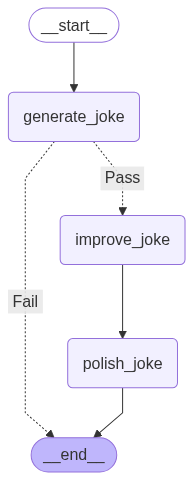

In [4]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

## Build the workflow
workflow = StateGraph(State)

## Add Nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

## Add Edges to connect Nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": END, "Pass": "improve_joke"}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

## Compile the workflow
chain = workflow.compile()

## Display workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [ ]:
## Invoke the Joke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

### 3. Parallelization

- In this Pattern all LLM Calls work in parallel and then it is passed on to an aggregator to generate output
- Every Sub-task can be parallelized: LLMs work simultaneously on a task
- Benefits: 
    - Need Multiple persepctives from one task (Multi-query RAG: One question >> Multiple sub-questions)
    - Independent tasks can be performed with different prompts 

- Structure: Input >> LLM Call 1 || LLM Call 2 || LLM Call 3 >> Aggregator >> Output


In [6]:
## Parallelization Example: User >> Topic >> Joke || Story || Poem >> Aggregator >> Combined Output

## Graph state for different stages (Topic, Joke, Story, Poem, Combined Output)
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [7]:
## Generate Nodes

## First LLM call to generate initial joke based on topic
def call_llm_1(state: State):
    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

## Second LLM call to generate story based on topic
def call_llm_2(state: State):
    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}

## Third LLM call to generate poem based on topic
def call_llm_3(state: State):
    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}

## Aggregator to combine the outputs into a single output
def aggregator(state: State):
    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}

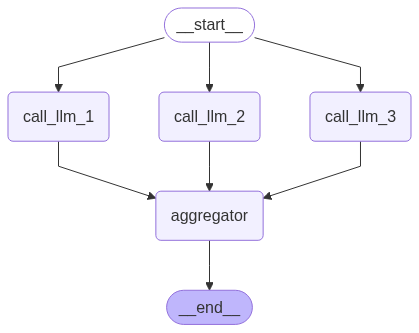

In [8]:
## Build workflow
parallel_builder = StateGraph(State)

## Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

## Add edges to connect nodes
## Here inorder to parallelize the LLM calls, we connect them all from START
## The outputs then converge at the Aggregator node and End after aggregation
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)

## Compile the workflow
parallel_workflow = parallel_builder.compile()

## Display workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [ ]:
# Invoke the Workflow
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

### 4. Routing

- It classifies an input and then directs it to a specialized follow up task
- Multiple LLM Calls are set up but the LLM Call Router decides which LLM Call should be invoked
- Benefits: Routing a particular task to different systems
    - Example: Routing a question to different retrieval systems

- Structure: Input >> LLM Call Router >> LLM Call 1/LLM Call 2/LLM Call 3 >> Output

In [ ]:
## Routing Example: User >> Input >> LLM Call Router >> Joke/Story/Poem >> Output

from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage


## Routing Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

## Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [10]:
## Graph State for different stages (Input, Decision, Output)
## Here the Decision stage consists of LLM Call Router and LLM Calls(Joke, Story, Poem)

class State(TypedDict):
    input: str
    decision: str
    output: str

In [ ]:
## Define the Nodes

## Here we haven't instructed the LLM calls to do anything definite as it based on user input
## Hence, we have just defined generic LLM call nodes for Story, Joke and Poem

## LLM call to write a story
def llm_call_1(state: State):
    print("Write a story")
    result = llm.invoke(state["input"])
    return {"output": result.content}

## LLM call to write a joke
def llm_call_2(state: State):
    print("Write a joke")
    result = llm.invoke(state["input"])
    return {"output": result.content}

### LLM call to write a poem
def llm_call_3(state: State):
    print("Write a poem")
    result = llm.invoke(state["input"])
    return {"output": result.content}

## LLM Call Router to decide which LLM call to invoke and generate based on user input
def llm_call_router(state: State):
    ## Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


## Conditional Edge function to route to the appropriate node
def route_decision(state: State):
    ## Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


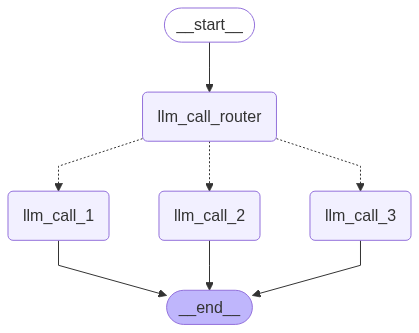

In [12]:
## Build workflow
router_builder = StateGraph(State)

## Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

## Add Edges to connect Nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  ## Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
## Connect all LLM calls to END as it is routing and will visit only one of them
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

## Compile workflow
router_workflow = router_builder.compile()

## Display the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [ ]:
# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

## 5. Orchestrator-Worker

- Orchestrator breaks the task into sub-tasks and delegates each sub-task to different workers
- Benefits: Requirement of breaking a complex task into simple tasks and alloting the right resources
    - Example: Planning a report where each LLM can define a section of the report

- Structure: Input >> Orchestrator >> LLM Call 1 + LLM Call 2 + LLM Call 3 >> Synthesizer >> Output
- Similar to parallelization but the workers assigned are not predefined
- The Orchestrator performs reasoning and then defines which sub-tasks should be alloted to which worker

In [ ]:
## Orchestrator-Worker Example: User >> Topic >> Orchestrator >> Plan Section >> Write Section >> Output

from typing import List
## Orchestrator-Worker Schema for structured output to use in planning
## Orchestrator creates a number of sections by reasoning the name and description of each section
## The number of sections and workers is not predefined and hence, the orchestrator reasons about them

class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

## Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [ ]:
from typing import Annotated
import operator

## Graph state for different Stages (Topic, Sections, Completed Section, Report)
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state for different stages (Section, Completed Section)
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [ ]:
## Define the  Nodes

from langgraph.types import Send

## Orchestrator that generates a plan for the report
def orchestrator(state: State):
    ## Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}

## Worker writes a section of the report
def llm_call(state: WorkerState):
    ## Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    ## Write the updated section to completed sections
    return {"completed_sections": [section.content]}

## Synthesize full report from sections
def synthesizer(state: State):
    ## List of completed sections
    completed_sections = state["completed_sections"]

    ## Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


## Conditional edge function to create llm_call workers that each write a section of the report
## Assign a worker to each section in the plan

def assign_workers(state: State):
    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

In [ ]:
## Build workflow
orchestrator_worker_builder = StateGraph(State)

## Add the Nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

## Add Edges to connect Nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

## Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

## Display the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [ ]:
## Invoke the Workflow
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

## 6. Evaluator-Optimizer Workflow

- LLM Call generates a response while the other LLM Call provides evaluation and feedback in a loop
- Benefits: Requirement to grade/check quality of responses/structured document
    -Example: Grading the quality of responses from a RAG System (Hallucinations/ Factual accuracies)

- Structure: Input >> LLM Call Generator >> [Solution] >> LLM Call Evaluator >> [Evaluation/Feedback] >> LLM Call Generator >> [Improved Solution] >> LLM Call Evaluator >> [Accepted] >> Output

- Solution and Evaluation/Feedback can be a multiple stage process and not just a single stage process

In [ ]:
## Evaluator-Optimizer Example: User >> Topic >> Joke >> Evaluation >> Feedback >> Output

## Graph state for different stages (Joke, Topic, Feedback, Evaluation)
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [ ]:
## Evaluator-Optimizer Schema for structured output to use in evaluation
## Defines Evaluation + Feedback by using a Grade and then creating a feedback gate based on the grade evaluated

class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


## Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [ ]:
## Define the Nodes

## LLM Call generates a joke
## While generating the joke it checks for feedback stage so that it is incorporated into the LLM Call
def llm_call_generator(state: State):
    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

## LLM Call evaluates the joke
def llm_call_evaluator(state: State):
    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


## Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    ## Route back to joke generator or end based upon feedback from the evaluator
    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


In [ ]:
## Build workflow
optimizer_builder = StateGraph(State)

## Add the Nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

## Add Edges to connect Nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  ## Name returned by route_joke : Name of next node to visit
       ## Conditional Edge based on Feedback generated
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

## Compile the workflow
optimizer_workflow = optimizer_builder.compile()

## Display the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [ ]:
# Invoke the Workflow
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])